# Phys 581 Winter 2019
# Assignment #5: Multiprocessing
## Alexander Hickey, 10169582

Note that this notebook makes use of the Keras deep learning library for python, which is compatible only with Python 2.7-3.6.

In [1]:
#Must be running Python 3.6 or lower!
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

In [2]:
#Import useful libraries
import time
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import subprocess
import psutil
from multiprocessing import Pool
from keras.models import Model, Sequential
from keras.layers import Input, Dense
%matplotlib inline

Using TensorFlow backend.


### Introduction

Parallel computing allows one to harness the processing power of a multi-core computer, and can significantly decrease the time required for repetitive computations. The idea behind parallel computing is to take a large problem and divide it into smaller ones which can be solved simultaneously, and allocate these different tasks to different parts of the CPU network. Often times, it is very powerful to implement parallel computing in the framework of scientific computations, to allow researchers to execute code and analyze output within a reasonable timeframe.

The goal of this notebook is to analyze the process of parallel computing in python, and the efficiency of distributing tasks across a multi-core processor. In particular, I will look at how the computational efficiency scales with the number of computationally intensive tasks, as well as how parallel computing can be used in the context of hyperparameter optimization for machine learning.

To analyze in detail how parallel processes get distributed over a multi-core processor, we will use the psutil library, which is used to retrieve information about running processes and system utilization (CPU, memory, disks, network, sensors) in Python. For hyperparameter optimization, we will use the multiprocessing package. For example, the psutil can be used to determine the number of cores on a given device.

In [3]:
print( 'number of physical cores: ', psutil.cpu_count(), '\n' )

number of physical cores:  4 



For referece, this notebook is being developped on one of the Linux machines in the PJL, each of which contains 4 cores.

### Task: determine scaling efficiency

The psutil library allows one to calculate the total CPU time spend on a task. To determine the scaling efficiency, we will compare this time to the so called wall time, which is the actual time elapsed. To start, we define some task that will be spawned multiple times in parallel.

In [4]:
#Define some arbitrary CPU intensive task to be run in the terminal
cmnd = 'python -c "[i**2 for i in range(9876543)]"'

Next, we define the function that will compute both the CPU and wall time for some set of processes that are spawned simultaneously.

In [5]:
def time_par(cmdlist, time_res = 1e-5):
    '''
    This function will compute both the CPU and wall time for a set
    of processes spawned simultaneously.
    
    Args:
        cmdlist: List of commands to track
        time_res: Time step between tracking
        
    Return:
        tlist: Array of both wall and cpu times for each process
               to terminate. Axis 0 corresponds to wall time,
               axis 1 corresponds to cpu time.
    
    '''
    
    #Spawn each process using the subprocess module.
    plist = [subprocess.Popen(cmnd, shell=True) for j in cmdlist]
    
    #Iitialize list of child processes and wall time
    ch_list = [0.0] 
    t0 = time.time()
    
    #Initialize dictionary that tracks CPU time while
    #processes are still running.
    t_dict = {p.pid:0.0 for p in plist}
    
    
    #Empty list of child processes signals all of them have terminated
    while ch_list != []:
        
        ch_list = []
        
        #Pause for timestep
        time.sleep(time_res)
        
        #Record wall/cpu time of each process if still running
        for p in plist:    
            
            child = psutil.Process(pid=p.pid).children()
            
            #Try to get info on process, if process has
            #terminated, psutil will return an exception error
            try:
                
                #Record cpu time of process
                proc = psutil.Process(pid=child[0].pid)
                cputime = proc.cpu_times().user
                
                #Record wall/cpu times in dictionary
                t_dict[p.pid] = [time.time()-t0,cputime]
                
                #Append to list of active processes
                ch_list.append(child)
                
            except:
                None
    
    
    return np.array([t_dict[key] for key in t_dict ])

def ratio(t):
    '''
    This function will compute the ratio of the average CPU time
    per process to the total wall time.
    
    Args:
        t: Array of both wall and cpu times. Axis 0 corresponds to wall time,
            axis 1 corresponds to cpu time.
        
    Return:
        tlist: Average CPU time divided by total wall time.
    
    '''
    
    return np.mean(t[:,1])/np.max(t[:,0])

Next, we look at how this efficiency scales with the number of processes given to the terminal.

In [6]:
N = 15
t_rat = []

for k in range(2,N+1):
    
    #Compute CPU/wall time
    t = time_par([cmnd for j in range(k)])
    t_rat.append(ratio(t))

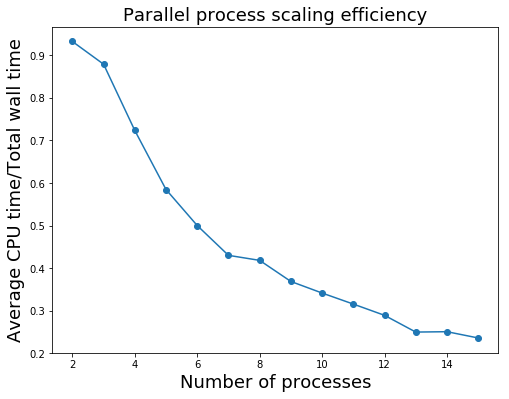

In [7]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(2,N+1),t_rat,marker = 'o')
plt.xlabel('Number of processes',fontsize = 18)
plt.ylabel('Average CPU time/Total wall time',fontsize = 18)
plt.title('Parallel process scaling efficiency',fontsize = 18)
plt.show()

We see that the average CPU time relative to the total wall time tends to decrease with the total number of processes. This is to be expected, as all of the processes are spawned simultaneously. Furthermore, we see that the efficiency tends to asymptote for large numbers of tasks, suggesting that the multi-core CPU eventually becomes saturated, in which case some of the tasks will need to wait for available memory to execute.

### Task: Use the multiprocessing package to speed up hyperparameter optimization.    

Next we will look at how the multiprocessing package can be used to speed up hyperparameter optimizations. Recall from the Neural Network assignment that the quality of fit from training a neural network depends largely on the hyperparameters used to define it. 

The code below is taken from Assignment #4, where we looked at predicting some timestep of given data for a Lorenz attractor. These functions are used to create and train a keras model for some given set of hyperparameters, and then compute the mean-square error by comparing to the actual data.

In [ ]:
def create_model(nodes=[8,11,6]):
    '''
    This function creates a dense Keras model with connectivity:
    3-nodes-3 where nodes represents the "deep" layers.
    
    Args:
        nodes: List describing number of deep layers and number of nodes at
               each layer. 
        
    Return:
        model: Dense Keras model with desired connectivity.
    
    '''
    #Create model
    model = Sequential()
    
    #Define input layer
    model.add(Dense(nodes[0], input_dim=3, activation='relu'))
    
    #Define "deep" layers
    for n in nodes[1:]:
        
        model.add(Dense(n, activation='relu'))
    
    #Define output layer
    model.add(Dense(3, activation='linear')) #sigmoid'))

    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model,xyz,epochs = 999,L=900,ndt=99):
    '''
    This function trains a given Keras model to shift a time series
    forward by some timestep ndt.
    
    Args:
        model: Keras model
        ndt: Timestep to shift time series
        xyz: 3D time series data
        L: Length of training interval
        epochs: Number of epochs to perform training
        
    Return:
        model: Trained model
    
    '''
    
    history = model.fit(xyz[:L],xyz[ndt:L+ndt], epochs=epochs, batch_size=100, 
                        verbose=0)
    
    return model

def mean_square(args):
    '''
    This function will compute the mean-squared error of a keras model with given hyperparameters,
    that attempt to predict some time shift in the given data set.
    
    Args:
        args = [nodes,epochs,xyz]
            nodes is the list specifying the connectivity of the keras model
            epochs is the number of training epochs
            xyz is the 3 dimensional data set
        
    Return:
        Mean squared error
    
    '''
    
    vs, ndt, L = 5000, 99, 900
    nodes,epochs,xyz = args
    mod = create_model(nodes = nodes)
    mod = train_model(mod,xyz,epochs = epochs)
    
    return np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:]-mod.predict(xyz[vs:vs+L]) )**2))

The following block of code will generate the Lorenz attractor trajectory that was studied in Assignment #4.

In [9]:
def dfunc(state, t0, sigma=10.0, beta=8/3.0, rho=58.0):
    '''
    This returns the time derivative of the coordinates,
    defined by the 3D Lorenz system:
    dx/dt = sigma*(y-x)
    dy/dt = x*(rho-z)-y
    dz/dt = x*y-beta*z
    
    Args:
        state: array of length 3, coordinates at time t0
        t0: Time
        sigma, beta, rho: Lorentz system parameters
        
    Return:
        d/dt state: array, Time derivative of coordinates
    
    '''
    
    #Unpack state vector
    x, y, z = state
    
    return np.array([ sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

#Define time interval of interest
t0, tf, tstep = 0.0, 20.0, 9999
tvals = np.linspace(t0, tf, tstep)

#Set initial state set to [1,1,1]
xyz_0 = np.ones(3)

#Integrate Lorenz system over time interval
xyz = scipy.integrate.odeint( dfunc, xyz_0, tvals )

It will be a good idea to store the number of cores, as this will most likely be the optimal number of processes to run simultaneously.

In [2]:
#Count number of cores
NCPU = psutil.cpu_count()

The hyperparameters of interest in this report are the number of layers, the number of nodes per layer, and the number of epochs during the training cycle. Starting with the number of layers, we can use the multiprocessing Pool object to compute the mean squared error for models trained with varying depth. Such tasks are computationally demanding, and each are independent of another, making this a good candidate to parallelize.

In [10]:
#List node schemes with varying number of layers
num_layers = [[5,8,5],[5,8,8,5],[5,8,8,8,5],[5,8,8,8,8,5],[5,8,8,8,8,8,5]]

#Number of training epochs
epochs = 999

#Pack into argument list
n_lay = [[num_layers[j],epochs,xyz] for j in range(len(num_layers))]

#Run in parallel, with NCPU=4 processes running simultaneously
if __name__ == '__main__':
    
    with Pool(NCPU) as p:
        m_square = p.map(mean_square, n_lay)

#Print results
for j in range(len(m_square)):
    
    print('Network: {} leads to a mean-square error of: {}'
                      .format(num_layers[j],m_square[j]))

Network: [5, 8, 5] leads to a mean-square error of: 9.108114893243906
Network: [5, 8, 8, 5] leads to a mean-square error of: 6.588264695195615
Network: [5, 8, 8, 8, 5] leads to a mean-square error of: 6.719830008721107
Network: [5, 8, 8, 8, 8, 5] leads to a mean-square error of: 7.998176976720634
Network: [5, 8, 8, 8, 8, 8, 5] leads to a mean-square error of: 3.0376666523178124


We see that increasing the model depth tends produce better models. This is most likely a result of the versatility of the model getting better with a more complex topology. Next, we consider the optimum model with 7 layers, and vary the number of nodes per layer.

In [11]:
#List node schemes with varying number of nodes per layer
layer_depth = [[5,2,2,5,2,2,5],[5,8,10,12,14,8,5],[5,16,16,16,16,16,5]]

#Number of training epochs
epochs = 999

#Pack into argument list
n_lay = [[layer_depth[j],epochs,xyz] for j in range(len(layer_depth))]

#Run in parallel, with NCPU=4 processes running simultaneously
if __name__ == '__main__':
    
    with Pool(NCPU) as p:
        m_square = p.map(mean_square, n_lay)

#Print results
for j in range(len(m_square)):
    
    print('Network: {} leads to a mean-square error of: {}'
                      .format(layer_depth[j],m_square[j]))

Network: [5, 2, 2, 5, 2, 2, 5] leads to a mean-square error of: 29.481753537461103
Network: [5, 8, 10, 12, 14, 8, 5] leads to a mean-square error of: 10.21615628181107
Network: [5, 16, 16, 16, 16, 16, 5] leads to a mean-square error of: 29.481753537461103


Interestingly, we see that the second model produces the best results. It seems that an increased number of nodes per layer will train better models, however, it is reasonable to assume that larger models will take longer to train. It follows that, when keeping the number of training epochs fixed, there will be some optimal number of nodes that can be trained efficiently. Finally, we look at how the results change with the number of training epochs.

In [12]:
#Fix node scheme
layer = [5,16,16,16,16,16,5]

#List varying number of training epochs
num_epochs = [599,999,1499,1999]

#Pack into argument list
n_lay = [[layer,num_epochs[j],xyz] for j in range(len(num_epochs))]

#Run in parallel, with NCPU=4 processes running simultaneously
if __name__ == '__main__':
    
    with Pool(NCPU) as p:
        m_square = p.map(mean_square, n_lay)

#Print results
for j in range(len(m_square)):
    
    print('{} Epochs leads to a mean-square error of: {}'
                      .format(num_epochs[j],m_square[j]))

599 Epochs leads to a mean-square error of: 31.357054918189938
999 Epochs leads to a mean-square error of: 29.481753537461103
1499 Epochs leads to a mean-square error of: 27.201603001270552
1999 Epochs leads to a mean-square error of: 24.980007423519613


As we see, the model becomes better trained with a larger number of training epochs. This is not too surprising, as the data will likely take a while to propagate through such a large neural network. Through all of the hyperparameters explored, we see that the [5,8,8,8,8,8,5] model produced the lowest mean square error. In this sense, it seems that the accuaracy of the neural network favours a large number of layers, with a reasonable low number of nodes per layer. These were analyzed at a fixed number of epochs, which seems to suggest that information is able to propagate through a network much more efficiently with a fewer number of nodes per layer.

### Conclusion

This notebook has examined the practice of parallel computing in python using multiprocessing, and how the efficiency of spawning multiple processes relates to how many processes we call. We saw that the CPU efficiency per process tends to get better and asymptote as the number of processes increases. This most likely is a result of the available hardware (i.e. number of cores), which would intuitively saturate and behave as if the tasks were being executed sequentially. Additionally, we looked at how parallel computing can be used for the application of hyperparameter optimization of neural networks, a task which is generally quite computationally demanding. Using a brute-force type approach, we were able to compare how the model accuract varies when changing different hyperparameters, and we were able to do this in a reasonable amound of time by exploiting the multiple cores available to us.

With more time available, it would be very interesting to see how these tasks could be distributed across an entire network of CPUs, rather than just a single device, a technique known as cluster computing.